In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import cooler
import cooltools.lib.plotting
from cooltools import insulation

from cooltools import api

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")



In [ ]:
!pwd

/Users/renhaoluo/Desktop/Harvard_Master/2022_Fall/HST.508/final_project/HST508_Fall2022_final_project/codes


In [ ]:
import cooltools
data_dir = '../data/'
# cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir=data_dir)
cool_file = data_dir + "4DNFI5QJNFAT.mcool"
print(cool_file)

../data/4DNFI5QJNFAT.mcool


In [ ]:
resolution = 10000
clr = cooler.Cooler(f'{data_dir}4DNFI5QJNFAT.mcool::resolutions/{resolution}')
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrX
INFO:root:Processing region chrY


In [ ]:
insulation_table.columns

Index(['sorting_index', 'chrom', 'start', 'end', 'region', 'is_bad_bin',
       'log2_insulation_score_30000', 'n_valid_pixels_30000',
       'log2_insulation_score_50000', 'n_valid_pixels_50000',
       'log2_insulation_score_100000', 'n_valid_pixels_100000',
       'log2_insulation_score_250000', 'n_valid_pixels_250000',
       'boundary_strength_30000', 'boundary_strength_50000',
       'boundary_strength_250000', 'boundary_strength_100000',
       'is_boundary_30000', 'is_boundary_50000', 'is_boundary_100000',
       'is_boundary_250000'],
      dtype='object')

In [ ]:
insulation_table

,sorting_index,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
0,0,chr1,0,10000,chr1,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
1,1,chr1,10000,20000,chr1,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
2,2,chr1,20000,30000,chr1,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
3,3,chr1,30000,40000,chr1,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
4,4,chr1,40000,50000,chr1,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272559,272559,chrY,91700000,91710000,chrY,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272560,272560,chrY,91710000,91720000,chrY,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272561,272561,chrY,91720000,91730000,chrY,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272562,272562,chrY,91730000,91740000,chrY,True,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False


In [ ]:
api.insulation.find_boundaries(insulation_table)

,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,log2_insulation_score_100000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
0,chr1,0,10000,chr1,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
1,chr1,10000,20000,chr1,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
2,chr1,20000,30000,chr1,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
3,chr1,30000,40000,chr1,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
4,chr1,40000,50000,chr1,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272559,chrY,91700000,91710000,chrY,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272560,chrY,91710000,91720000,chrY,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272561,chrY,91720000,91730000,chrY,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False
272562,chrY,91730000,91740000,chrY,True,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,False,False,False


In [ ]:
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]

insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)].iloc[1000:1005]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
1000,chr1,10000000,10010000,chr1,False,0.376886,622.0,NaN,False
1001,chr1,10010000,10020000,chr1,False,0.325722,622.0,NaN,False
1002,chr1,10020000,10030000,chr1,False,0.275033,622.0,NaN,False
1003,chr1,10030000,10040000,chr1,False,0.221361,622.0,NaN,False
1004,chr1,10040000,10050000,chr1,False,0.176824,622.0,NaN,False


In [ ]:
insulation_table[insulation_table["chrom"] == "chr1"]["log2_insulation_score_250000"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
19543   NaN
19544   NaN
19545   NaN
19546   NaN
19547   NaN
Name: log2_insulation_score_250000, Length: 19548, dtype: float64

In [ ]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [ ]:
windows[0]

30000

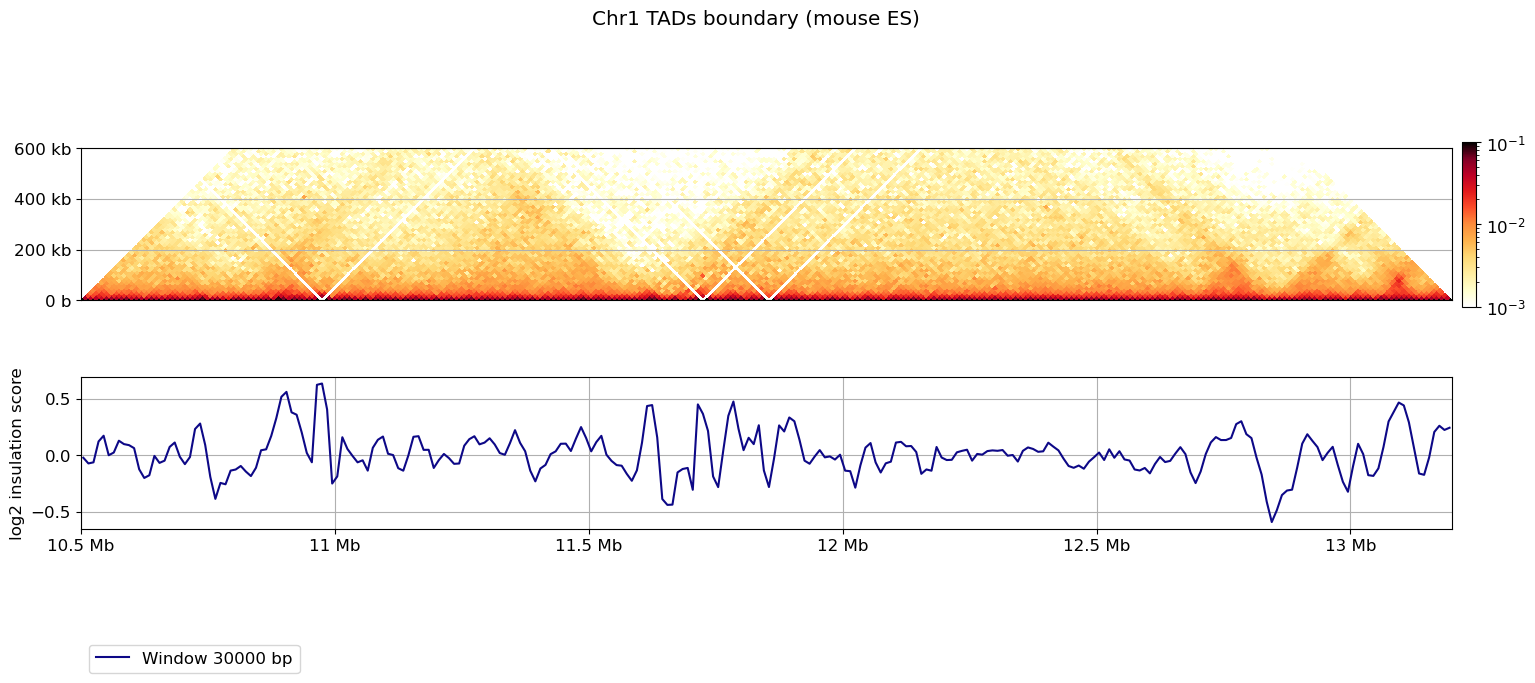

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('chr1', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0]) # adjust y
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])
ax.grid()
f.suptitle("Chr1 TADs boundary (mouse ES)");

In [ ]:
windows

[30000, 50000, 100000, 250000]

In [ ]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4)



/var/folders/24/6z460d797_g0w77wl1mc7jqr0000gn/T/ipykernel_40005/2585630840.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


In [ ]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

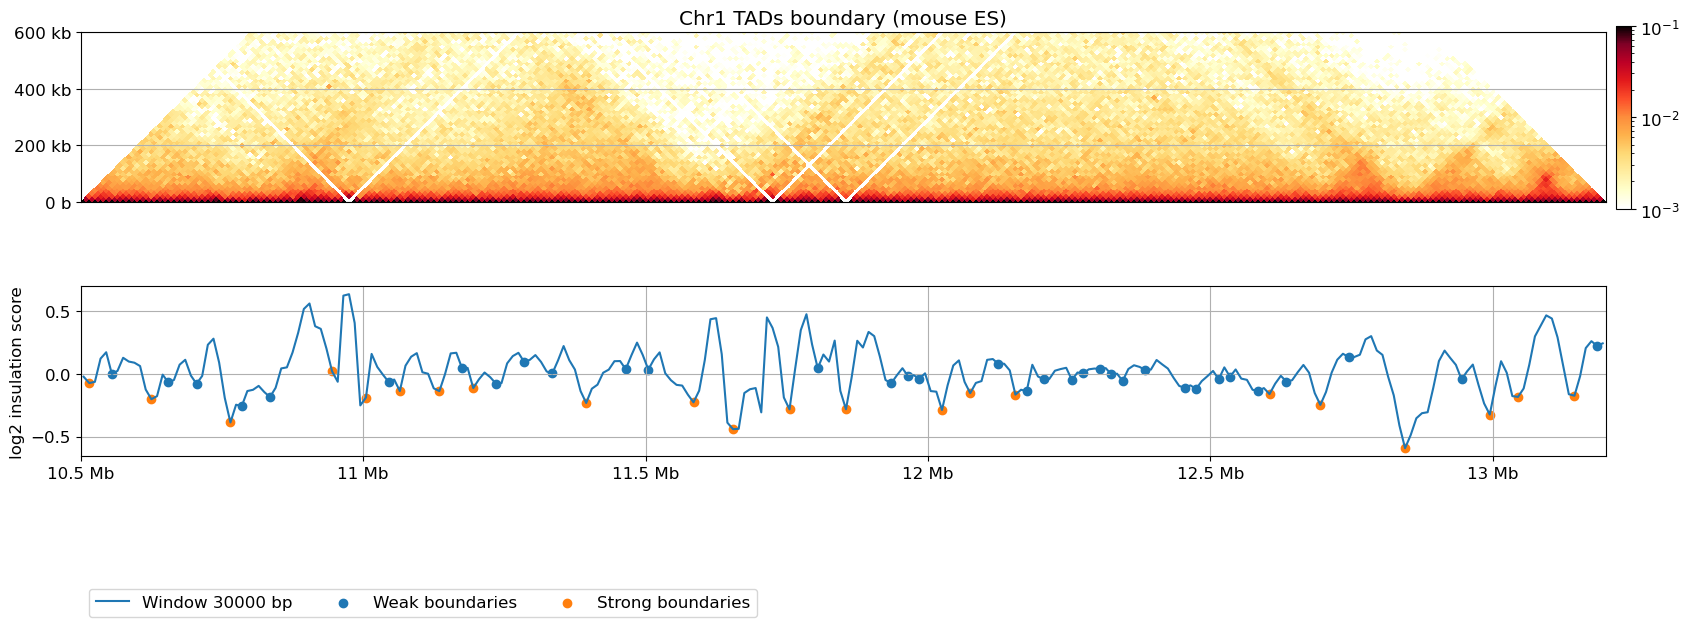

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

ax.grid()
ax.set_title("Chr1 TADs boundary (mouse ES)");

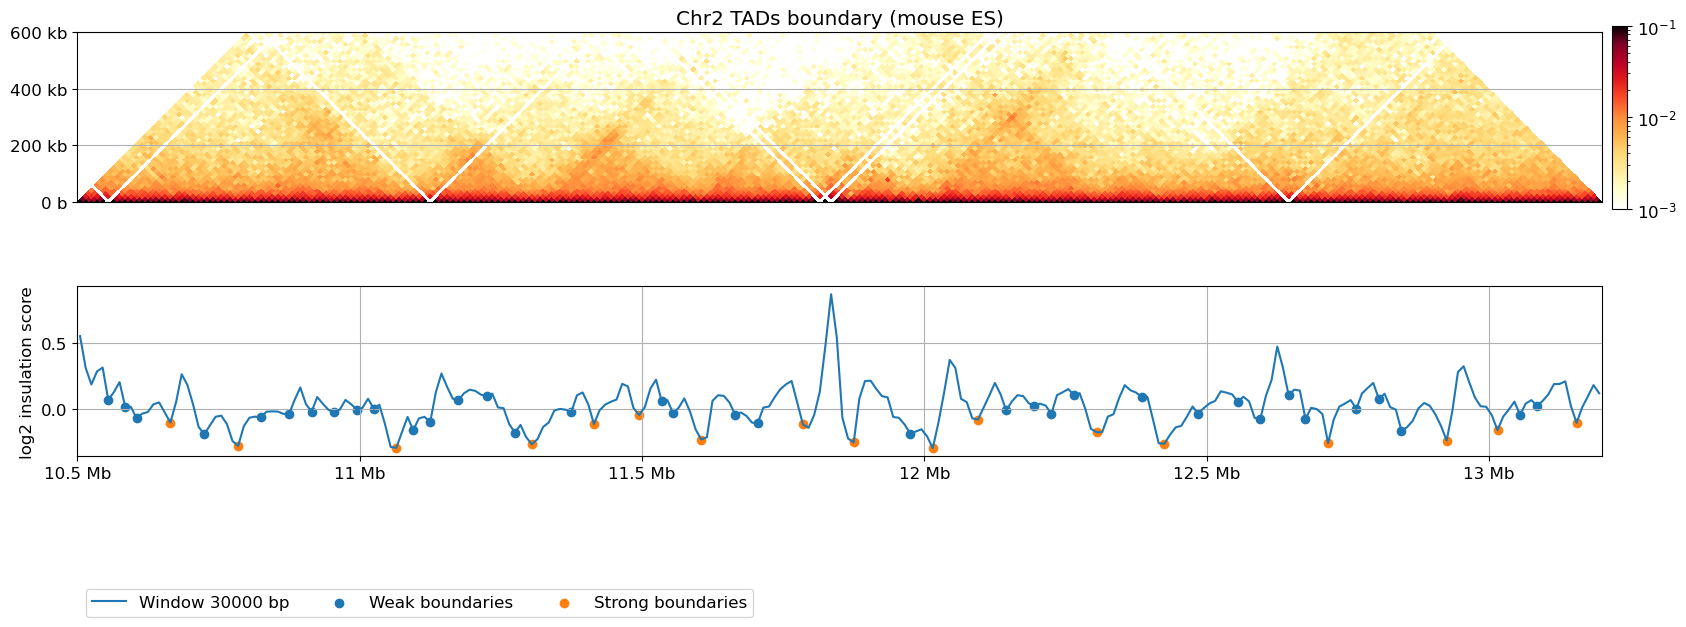

In [ ]:
start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

ax.grid()
ax.set_title("Chr2 TADs boundary (mouse ES)");

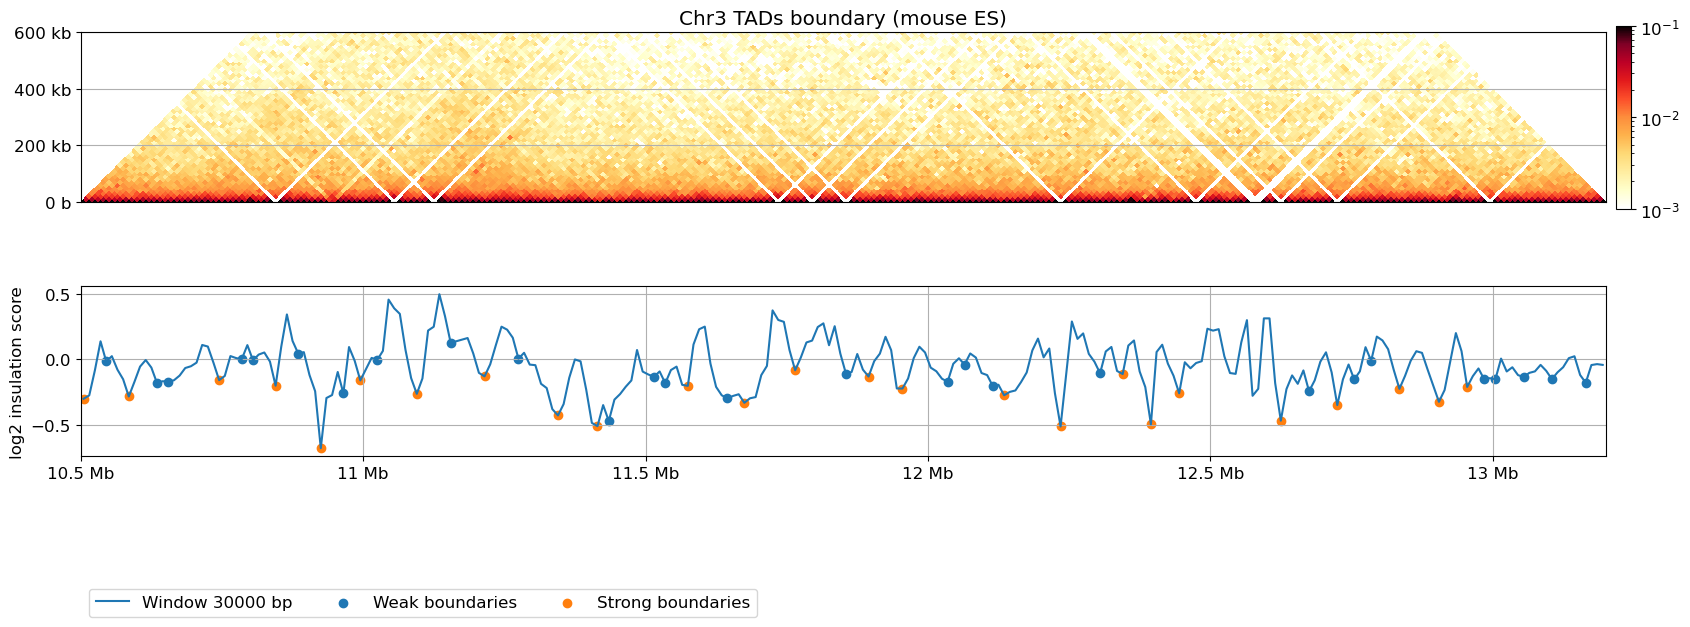

In [ ]:
start = 10_500_000
end = start+ 90*windows[0]
region = ('chr3', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

ax.grid()
ax.set_title("Chr3 TADs boundary (mouse ES)");

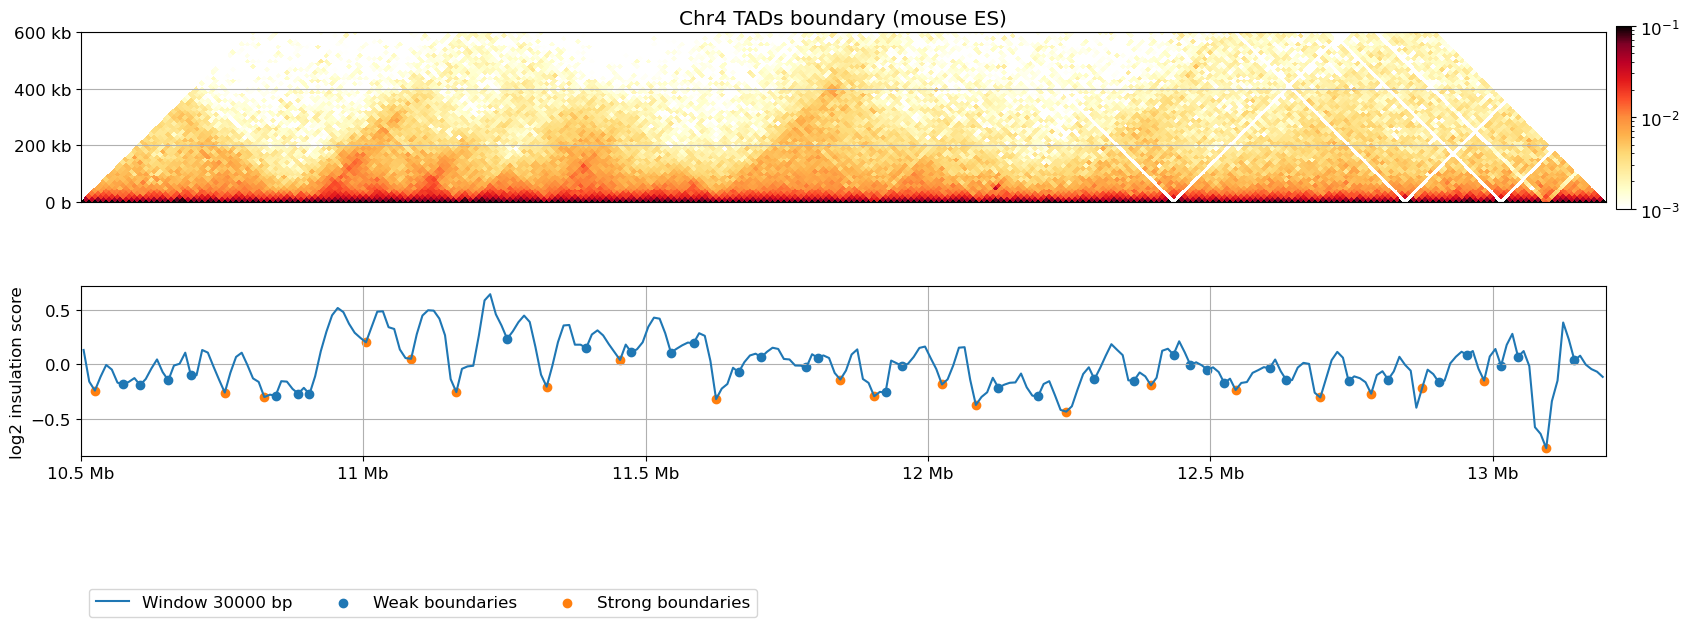

In [ ]:
start = 10_500_000
end = start+ 90*windows[0]
region = ('chr4', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

ax.grid()
ax.set_title("Chr4 TADs boundary (mouse ES)");

In [ ]:
strong_boundaries

,sorting_index,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
54816,54816,chr4,10520000,10530000,chr4,False,-0.240174,6.0,-0.186030,22.0,...,0.219166,622.0,0.372843,0.292825,NaN,0.288775,True,True,True,False
54839,54839,chr4,10750000,10760000,chr4,False,-0.258381,6.0,-0.062496,22.0,...,-0.026291,622.0,0.366010,0.136336,NaN,NaN,True,False,False,False
54846,54846,chr4,10820000,10830000,chr4,False,-0.299661,6.0,-0.244767,22.0,...,-0.426241,622.0,0.675150,NaN,NaN,NaN,True,False,False,False
54864,54864,chr4,11000000,11010000,chr4,False,0.203353,6.0,0.347029,22.0,...,0.292107,622.0,0.284775,NaN,NaN,NaN,True,False,False,False
54872,54872,chr4,11080000,11090000,chr4,False,0.051733,6.0,0.159553,22.0,...,0.365310,622.0,0.446020,NaN,NaN,NaN,True,False,False,False
54880,54880,chr4,11160000,11170000,chr4,False,-0.254348,6.0,-0.108586,22.0,...,0.103099,622.0,0.772756,NaN,NaN,NaN,True,False,False,False
54896,54896,chr4,11320000,11330000,chr4,False,-0.204483,6.0,-0.009249,22.0,...,0.183708,622.0,0.634300,0.385566,NaN,NaN,True,True,False,False
54909,54909,chr4,11450000,11460000,chr4,False,0.040779,6.0,0.049055,22.0,...,0.160619,622.0,0.321605,0.277828,NaN,NaN,True,True,False,False
54926,54926,chr4,11620000,11630000,chr4,False,-0.318900,6.0,-0.245403,22.0,...,-0.474458,622.0,0.483064,NaN,NaN,NaN,True,False,False,False
54948,54948,chr4,11840000,11850000,chr4,False,-0.138821,6.0,-0.039271,22.0,...,0.416413,622.0,0.277048,0.027533,NaN,NaN,True,False,False,False


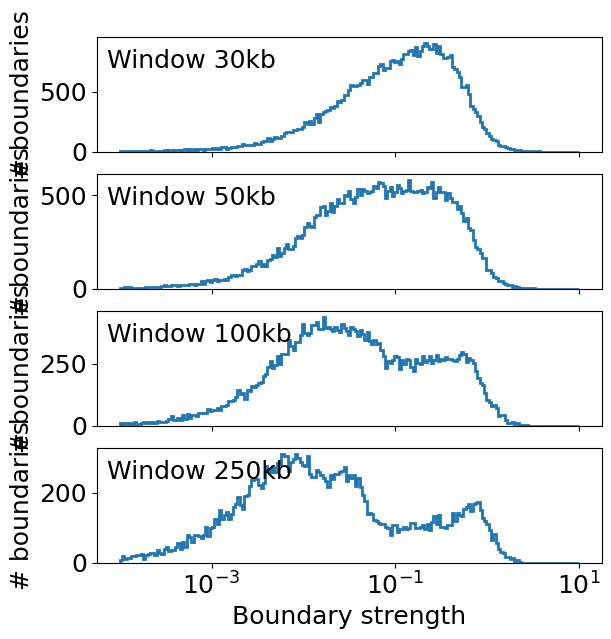

In [ ]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(6,6), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    ax.text(0.02, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength');

[Text(0.5, 0, 'Boundary strength')]

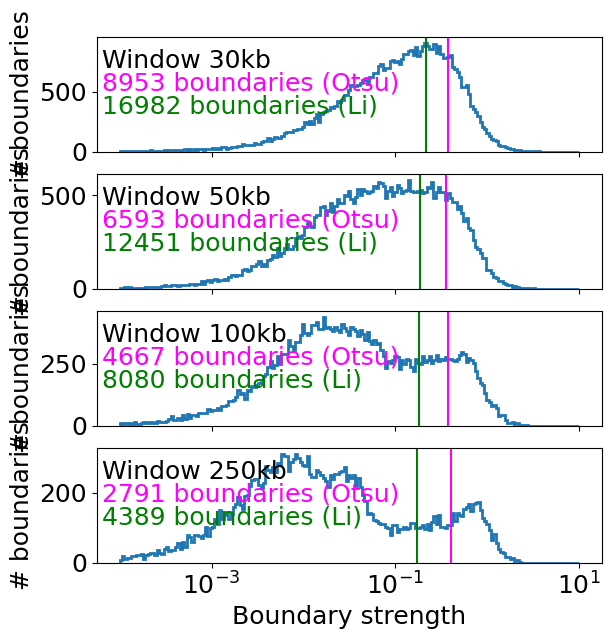

In [ ]:
from skimage.filters import threshold_li, threshold_otsu

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength')

## extract the TAD boundaries

,sorting_index,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
20598,20598,chr2,10500000,10510000,chr2,False,0.551416,1.0,0.312172,13.0,...,-0.052831,550.0,NaN,NaN,NaN,NaN,False,False,False,False
20599,20599,chr2,10510000,10520000,chr2,False,0.310835,3.0,0.398375,9.0,...,-0.022787,549.0,NaN,NaN,NaN,0.020998,False,False,False,False
20600,20600,chr2,10520000,10530000,chr2,False,0.185874,6.0,0.523542,9.0,...,0.020146,549.0,NaN,NaN,NaN,NaN,False,False,False,False
20601,20601,chr2,10530000,10540000,chr2,False,0.283998,3.0,0.322189,13.0,...,0.052070,549.0,NaN,NaN,NaN,0.009069,False,False,False,False
20602,20602,chr2,10540000,10550000,chr2,False,0.313586,4.0,0.164229,18.0,...,0.088049,550.0,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20863,20863,chr2,13150000,13160000,chr2,False,-0.104351,6.0,0.018111,22.0,...,-0.177654,622.0,0.28524,0.045266,NaN,NaN,True,False,False,False
20864,20864,chr2,13160000,13170000,chr2,False,0.012812,6.0,0.027326,22.0,...,-0.224173,622.0,NaN,NaN,NaN,0.006098,False,False,False,False
20865,20865,chr2,13170000,13180000,chr2,False,0.095259,6.0,0.057949,22.0,...,-0.263341,622.0,NaN,NaN,NaN,NaN,False,False,False,False
20866,20866,chr2,13180000,13190000,chr2,False,0.180889,6.0,0.063378,22.0,...,-0.318893,622.0,NaN,NaN,NaN,NaN,False,False,False,False


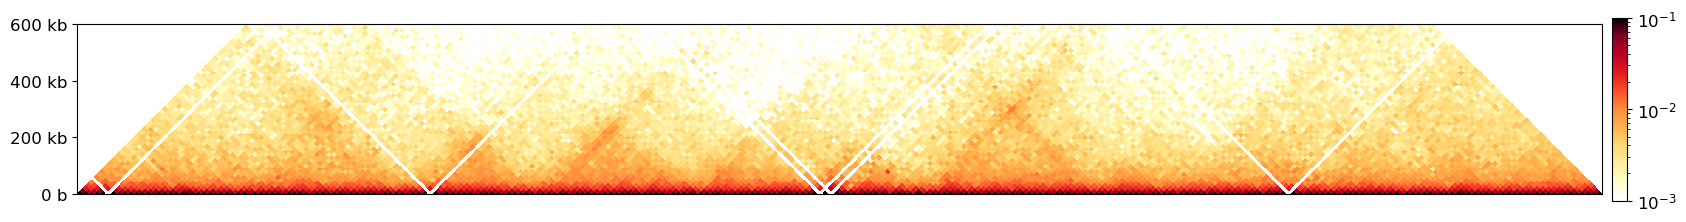

In [ ]:
start = 10_500_000
end = start+ 90*windows[0]
region = ('chr4', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')




In [ ]:
all_chrom = ["chr"+str(i) for i in range(1,20)] + ["chrX", "chrY"]
all_chrom
windows_size=30000
insulation_table[insulation_table["chrom"] == "chr2"]

start = 0
end = max(insulation_table[insulation_table["chrom"] == "chr2"]["end"])
region = ('chr2', start, end)

insul_region = bioframe.select(insulation_table, region)
boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows_size}'])]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows_size}']]
TAD_boundary_location = strong_boundaries[['start', 'end']].mean(axis=1)


In [ ]:
boundaries

,sorting_index,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,log2_insulation_score_50000,n_valid_pixels_50000,...,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_30000,boundary_strength_50000,boundary_strength_250000,boundary_strength_100000,is_boundary_30000,is_boundary_50000,is_boundary_100000,is_boundary_250000
19858,19858,chr2,3100000,3110000,chr2,False,0.604180,6.0,0.684200,17.0,...,1.265418,122.0,0.113288,NaN,NaN,NaN,False,False,False,False
19860,19860,chr2,3120000,3130000,chr2,False,0.622980,6.0,0.627731,22.0,...,1.243880,172.0,0.016288,0.092709,NaN,NaN,False,False,False,False
19863,19863,chr2,3150000,3160000,chr2,False,0.649969,6.0,0.756507,22.0,...,1.144304,247.0,0.018560,NaN,NaN,NaN,False,False,False,False
19871,19871,chr2,3230000,3240000,chr2,False,0.346450,6.0,0.398289,22.0,...,0.678005,447.0,0.266187,0.060833,NaN,NaN,True,False,False,False
19876,19876,chr2,3280000,3290000,chr2,False,0.232268,6.0,0.316382,22.0,...,0.399928,572.0,0.422592,0.037163,NaN,NaN,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37719,37719,chr2,181710000,181720000,chr2,False,0.241683,6.0,0.369871,22.0,...,0.248448,597.0,0.411052,NaN,NaN,NaN,True,False,False,False
37725,37725,chr2,181770000,181780000,chr2,False,0.436845,6.0,0.668870,22.0,...,0.604900,572.0,0.192459,NaN,NaN,NaN,False,False,False,False
37731,37731,chr2,181830000,181840000,chr2,False,0.455460,6.0,0.550962,22.0,...,0.838652,422.0,0.082060,NaN,NaN,NaN,False,False,False,False
37734,37734,chr2,181860000,181870000,chr2,False,0.472139,6.0,0.596199,17.0,...,0.867594,347.0,0.011751,NaN,NaN,NaN,False,False,False,False


In [ ]:
df = pd.DataFrame(TAD_boundary_location,columns=["TAD_strong_boundary"])
df["chrom"] = "chr2"
df

,TAD_strong_boundary,chrom
19871,3235000.0,chr2
19876,3285000.0,chr2
19881,3335000.0,chr2
19889,3415000.0,chr2
19902,3545000.0,chr2
...,...,...
37685,181375000.0,chr2
37698,181505000.0,chr2
37707,181595000.0,chr2
37719,181715000.0,chr2


In [ ]:
all_chrom = ["chr"+str(i) for i in range(1,20)] + ["chrX", "chrY"]
all_chrom
windows_size=30000

final_TAD_boundary_df = pd.DataFrame( columns=["TAD_strong_boundary", "chrom"])

for i, selected_chr in enumerate(all_chrom):
    start = 0
    end = max(insulation_table[insulation_table["chrom"] == selected_chr]["end"])
    region = (selected_chr, start, end)

    insul_region = bioframe.select(insulation_table, region)
    boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows_size}'])]
    strong_boundaries = boundaries[boundaries[f'is_boundary_{windows_size}']]
    TAD_boundary_location = strong_boundaries[['start', 'end']].mean(axis=1)
    
    df = pd.DataFrame(TAD_boundary_location,columns=["TAD_strong_boundary"])
    df["chrom"] = selected_chr
    final_TAD_boundary_df = pd.concat([final_TAD_boundary_df, df],ignore_index=True)

In [ ]:
final_TAD_boundary_df

,TAD_strong_boundary,chrom
0,3185000.0,chr1
1,3225000.0,chr1
2,3295000.0,chr1
3,3545000.0,chr1
4,3665000.0,chr1
...,...,...
16977,169585000.0,chrX
16978,169675000.0,chrX
16979,169775000.0,chrX
16980,169855000.0,chrX


In [ ]:
final_TAD_boundary_start_end_df = pd.DataFrame(columns=["chrom", "start", "end"])

for ind in final_TAD_boundary_df.index:
    chrom_value = final_TAD_boundary_df['chrom'][ind]
    if ind != max(final_TAD_boundary_df.index):
        start_pos = final_TAD_boundary_df['TAD_strong_boundary'][ind]
        end_pos = final_TAD_boundary_df['TAD_strong_boundary'][ind+1]

    temp_df = pd.DataFrame({"chrom":chrom_value, "start":start_pos, "end":end_pos}, index=["0"])
    final_TAD_boundary_start_end_df = pd.concat([final_TAD_boundary_start_end_df,temp_df], ignore_index=True)
final_TAD_boundary_start_end_df

TypeError: Index(...) must be called with a collection of some kind, 0 was passed